In [92]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize



In [124]:
class MultiLabelClassifier:
    def __init__(self, classifier):
        self.classifier = classifier
        self.ova_classifier = None
        self.best_estimator = None
        self.num_classes = 9
        self.all_fpr = []
        self.all_tpr = []
        self.all_auc = []

    def train(self, X, y, n_components=None, degree=None):
        if n_components is not None:
            self.pca = PCA(n_components=n_components)
            X = self.pca.fit_transform(X)
        
        if degree is not None:
            self.poly = PolynomialFeatures(degree=degree)
            X = self.poly.fit_transform(X)
        
        self.ova_classifier = OneVsRestClassifier(self.classifier)
        self.ova_classifier.fit(X, y)
        
        self.best_estimator = self.ova_classifier

    def grid_search(self, X, y, parameter_grid, scoring_metric, n_components=None, degree=None):
        if n_components is not None:
            self.pca = PCA(n_components=n_components)
            X = self.pca.fit_transform(X)
        
        if degree is not None:
            self.poly = PolynomialFeatures(degree=degree)
            X = self.poly.fit_transform(X)
        
        scorer = make_scorer(scoring_metric)
        grid_search = GridSearchCV(self.ova_classifier, parameter_grid, scoring=scorer, cv=10, verbose=10)
        grid_search.fit(X, y)
        
        self.best_estimator = grid_search.best_estimator_
        
        # Predict the y values using the best estimator
        y_pred = self.best_estimator.predict(X)
        
        # Perform majority voting (hard voting)
        y_pred_majority = np.array([np.argmax(pred) for pred in y_pred.T])
        
        return grid_search.best_params_, grid_search.best_score_, y_pred_majority

    def predict(self, X):
        return self.best_estimator.predict(X)
    
    def compute_roc_curve(self, y_true, y_scores):
        # Convert y_true to one-hot encoded format
        y_true_one_hot = np.eye(self.num_classes)[y_true.astype(int)]
        
        # Iterate over each class
        for class_index in range(self.num_classes):
            # Extract scores for the current class
            scores = y_scores[:, class_index]
            
            # Compute fpr, tpr, and thresholds for the current class
            fpr, tpr, thresholds = roc_curve(y_true_one_hot[:, class_index], scores)
            
            # Compute the area under the ROC curve (AUC) for the current class
            roc_auc = auc(fpr, tpr)
            
            # Store the fpr, tpr, and auc for the current class
            self.all_fpr.append(fpr)
            self.all_tpr.append(tpr)
            self.all_auc.append(roc_auc)
    
    def plot_roc_curve(self):
        # Plot the ROC curve for each class
        plt.figure(figsize=(10, 6))
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Customize colors for each class
        for class_index in range(self.num_classes):
            plt.plot(self.all_fpr[class_index], self.all_tpr[class_index], color=colors[class_index], 
                     label='Class {0} (AUC = {1:.2f})'.format(class_index, self.all_auc[class_index]))
    
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Multiclass Classification')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()


In [69]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()


data = pd.read_csv(r'../out/features_selected/breakhis_selected_features_train.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_train = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_train = data.iloc[:, -1]

# print(Y_train)

from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = OneHotEncoder()

# Fit label encoder on Y_train and transform the labels
Y_tr_encoded = label_encoder.fit_transform(Y_train)
Y_tr = Y_tr_encoded.reshape(-1, 1)

# print(Y_tr)
# Y_tr = mlb.fit_transform(Y_tr)

data = pd.read_csv(r'../out/features_selected/breakhis_selected_features_validation.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_validation = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_validation = data.iloc[:, -1]

Y_val_encoded = label_encoder.fit_transform(Y_validation)
Y_val = Y_val_encoded.reshape(-1, 1)

data = pd.read_csv(r'../out/features_selected/breakhis_selected_features_test.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_test = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_test = data.iloc[:, -1]

Y_t_encoded = label_encoder.fit_transform(Y_test)
Y_t = Y_val_encoded.reshape(-1, 1)


In [70]:
X_train.shape

(995, 120)

In [71]:
parameter_grid_rf = {'estimator__n_estimators': [100, 200, 300], 'estimator__max_depth': [None, 5, 10]}
parameter_grid_svm = {'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['linear', 'rbf']}
parameter_grid_knn = {'estimator__n_neighbors': [3,4,5, 7], 'estimator__weights': ['uniform', 'distance']}

# Step 4: Train each MultiLabelClassifier
multi_label_classifier_rf = MultiLabelClassifier(RandomForestClassifier())  # Use RandomForestClassifier directly
multi_label_classifier_svm = MultiLabelClassifier(SVC())
multi_label_classifier_knn = MultiLabelClassifier(KNeighborsClassifier())

components = None
degree = None

# Step 5: Train each MultiLabelClassifier
multi_label_classifier_rf.train(X_train, Y_tr, degree=degree)
multi_label_classifier_svm.train(X_train, Y_tr, degree=degree)
multi_label_classifier_knn.train(X_train, Y_tr, degree=degree)

# Step 6: Perform grid search using each MultiLabelClassifier
best_params_rf, best_score_rf, y_pred_majority_rf = multi_label_classifier_rf.grid_search(X_validation, Y_val, parameter_grid_rf, accuracy_score, n_components=components, degree=degree)
best_params_svm, best_score_svm, y_pred_majority_svm = multi_label_classifier_svm.grid_search(X_validation, Y_val, parameter_grid_svm, accuracy_score, n_components=components, degree=degree)
best_params_knn, best_score_knn, y_pred_majority_knn = multi_label_classifier_knn.grid_search(X_validation, Y_val, parameter_grid_knn, accuracy_score, n_components=components, degree=degree)



Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 1/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.510 total time=   2.4s
[CV 2/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 2/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.520 total time=   2.5s
[CV 3/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 3/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.490 total time=   2.4s
[CV 4/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 4/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.450 total time=   2.4s
[CV 5/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 5/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.530 total time=   2.4s

In [72]:
# Step 6: Print the best parameters, their corresponding scores, and the predicted y values using majority voting for each classifier
print("Random Forest - Best Parameters: ", best_params_rf)
print("Random Forest - Best Score: ", best_score_rf)
print()
print("SVM - Best Parameters: ", best_params_svm)
print("SVM - Best Score: ", best_score_svm)
print()
print("K-Nearest Neighbors - Best Parameters: ", best_params_knn)
print("K-Nearest Neighbors - Best Score: ", best_score_knn)

Random Forest - Best Parameters:  {'estimator__max_depth': None, 'estimator__n_estimators': 300}
Random Forest - Best Score:  0.5176767676767676

SVM - Best Parameters:  {'estimator__C': 1, 'estimator__kernel': 'rbf'}
SVM - Best Score:  0.5618383838383838

K-Nearest Neighbors - Best Parameters:  {'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}
K-Nearest Neighbors - Best Score:  0.48545454545454547


In [73]:
rf_prediction = multi_label_classifier_rf.predict(X_test)
SVM_predict = multi_label_classifier_svm.predict(X_test)
KNN_predict = multi_label_classifier_knn.predict(X_test)


In [134]:
Y_t

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Perform label binarization
lb = LabelBinarizer()
Y_binary = lb.fit_transform(Y_t)

print(Y_binary)

for i in range(len(rf_prediction)):
    fpr[i], tpr[i], _ = roc_curve(Y_binary.ravel(), rf_prediction[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label='Label {} AUC = {:.2f}%'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


TypeError: Singleton array 0 cannot be considered a valid collection.

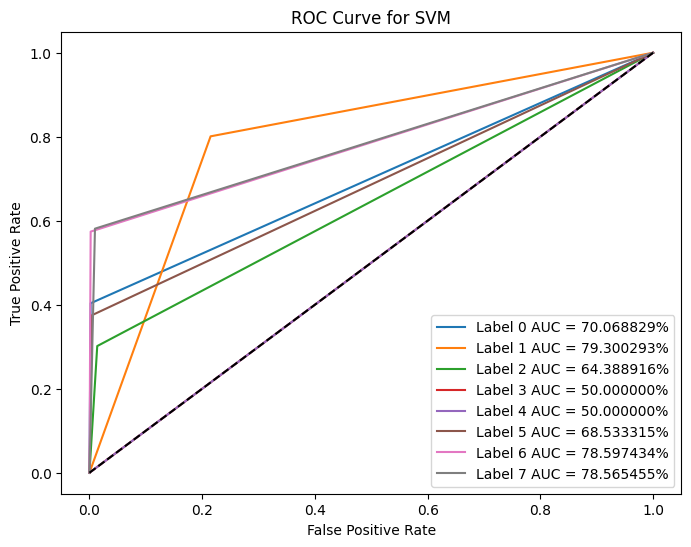

In [38]:
# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_t[:, i], SVM_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label='Label {} AUC = {:%}'.format(i,roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc='lower right')
plt.show()

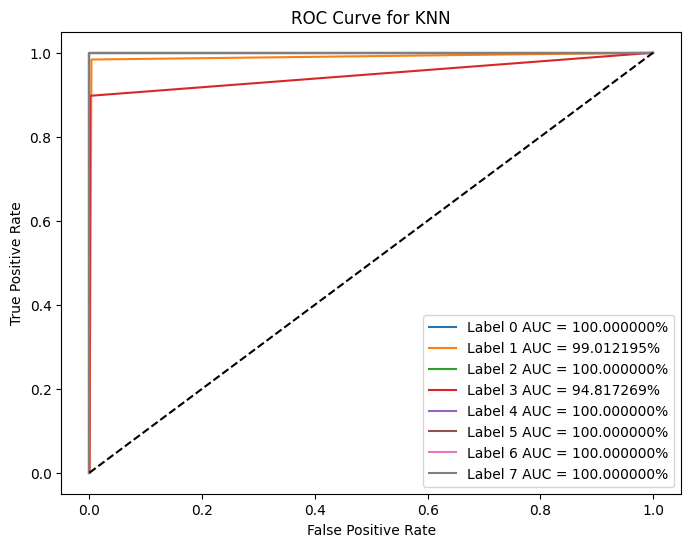

In [39]:
# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_t[:, i], KNN_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label='Label {} AUC = {:%}'.format(i,roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend(loc='lower right')
plt.show()